In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import numpy as np
from rdkit.Chem import Draw
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import precision_recall_curve
import seaborn as sns; sns.set()

RDKit WARNING: [11:11:00] Enabling RDKit 2019.09.3 jupyter extensions


In [4]:
data = pd.read_csv('/home/valeriia/bakalarka/bakalarka/LXRb_ch25_curated_DW_2.csv')
# copy raw data
data_new = data.copy()
data_new["Molecule"] = [Chem.MolFromSmiles(mol) for mol in data["smiles"]]

#colmun['Molecule'] invert to binary systems
data_new['bin'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in data_new['Molecule']]


In [5]:
data[:5]

smiles      chembl_id   potency  \
0   Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C     CHEMBL1023   434.000   
1  CCc1nc2c(cccc2nc1c3ccc(cc3)c4cccc(c4)S(=O)(=O)...  CHEMBL1089232  2805.000   
2  CS(=O)(=O)c1cccc(c1)c2ccc(CN(Cc3ccc(F)cc3Cl)S(...  CHEMBL1091034     3.162   
3  Cc1ccccc1S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O)...  CHEMBL1091976     3.162   
4  Cn1cnc(c1)S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O...  CHEMBL1092952    79.430   

      pec50  category  
0  6.362510    active  
1  5.569777  inactive  
2  8.500038    active  
3  8.500038    active  
4  7.100015    active

In [6]:
data_new.pec50.min()

3.9023956711255896

In [7]:
data_new.pec50.max()

9.0

In [42]:
##### classifikation model change thre and than i compare date for diferent thre
#this model predict active/inactive compounds
random_state = 20
thre = 5

#add new columns, number of columns
data_new['number'] = data_new['chembl_id'].rank(method='min')
lab_enc = preprocessing.LabelEncoder()
data_new['number']= lab_enc.fit_transform(data_new['number'])
data_new['category_new'] = np.where(data_new['pec50']>=thre, 1, 0)

#divided date for two sets: train and test
train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train, test = train.copy(), test.copy()
x_train = np.asarray([x for x in train['bin']])
x_test = np.asarray([x for x in test['bin']]) 
y_train = np.asarray([y for y in train['category_new']])
y_test = np.asarray([y for y in test['category_new']])

#RandomForesrClassifier
crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
crf.fit(x_train,y_train)

# prediction on test set
crf_predict = crf.predict(x_test)

#CLassification:
   #accuracy, spe, sen, MCC,
    #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
#confusion_matrix
print("Confusion_matrix for test set:")
conf_matrix = confusion_matrix(crf.predict(x_test), y_test)
print(conf_matrix)
TN, FP, FN, TP = conf_matrix.ravel()
d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
df = pd.DataFrame(data=d)
print("\n")
print(df)
print("\n")

#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
print("\n")
print("=== Classification Report ===")
print(classification_report(y_test, crf_predict))

# Performance metrics
errors = abs(crf_predict - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity:", round(TPR,3))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specifity:", round(TNR, 3))
#MCC
MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
print("MMC:", round(MCC, 3))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive predictive", round(PPV,3))
# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive", round(NPV,3))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive", round(FPR,3))
# False negative rate
FNR = FN/(TP+FN)
print("False negative", round(FNR,3))
# False discovery rate
FDR = FP/(TP+FP)
print("False discovery", round(FDR,3))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy", round(ACC,3))

#put data for pandas data_out
try:
    da = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
      'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
    dff = pd.DataFrame(data=da)

    data_out = data_out.append(dff, ignore_index = True)
    data_out.drop_duplicates(keep='first', inplace=True)
except:
    daa = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
      'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
    data_out = pd.DataFrame(data=daa)



y_score1 = crf.predict_proba(x_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))

#PLOT ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('ROC cuves')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate(TP)')
plt.xlabel('False Positive Rate(FP)')
plt.show()




#cross-validation
crf.score(x_test, y_test)

Confusion_matrix for test set:
[[115  11]
 [ 11 133]]


            predicted+  predicted-
0  actual+         133          11
1  actual-          11         115


Accuracy: 0.9185185185185185


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       126
           1       0.92      0.92      0.92       144

    accuracy                           0.92       270
   macro avg       0.92      0.92      0.92       270
weighted avg       0.92      0.92      0.92       270

Average absolute error: 0.08 degrees.
Sensitivity: 0.924
Specifity: 0.913
MMC: 0.836
Positive predictive 0.924
Negative predictive 0.913
False positive 0.087
False negative 0.076
False discovery 0.076
Overall accuracy 0.919
roc_auc_score for RandomForestClassification:  0.9528


0.9185185185185185

In [38]:
data_out.head()

threshold  Accuracy  Sensitiv.   Specif.       MCC  Positive pred  \
0        5.0  0.918519   0.923611  0.912698  0.836310       0.923611   
1        5.5  0.870370   0.852713  0.886525  0.740154       0.873016   
2        6.0  0.800000   0.880000  0.781818  0.542414       0.478261   
3        6.5  0.803704   0.923077  0.797665  0.362823       0.187500   
4        7.0  0.881481   1.000000  0.878327  0.397050       0.179487   

   Negative pred  False positive  False negative  
0       0.912698        0.087302        0.076389  
1       0.868056        0.113475        0.147287  
2       0.966292        0.218182        0.120000  
3       0.995146        0.202335        0.076923  
4       1.000000        0.121673        0.000000

In [39]:
data_out.to_csv('data_out_diferent_threshold_clasification_model.csv', encoding='utf-8')

In [111]:
n_splits = 10
thre = 7
random_state = 20

#add new columns, number of columns
data_new['number'] = data_new['chembl_id'].rank(method='min')
lab_enc = preprocessing.LabelEncoder()
data_new['number']= lab_enc.fit_transform(data_new['number'])
data_new['category_new'] = np.where(data_new['pec50']>=thre, 1, 0)

#print("crf_score", crf.score(x_test, y_test))
cros_x = np.asarray([x for x in data_new['bin']])
cros_y = np.asarray([y for y in data_new['category_new']])
#scores = cross_val_score(crf, cros_x, cros_y, cv=n_splits)
#print("Cross_val_scores",scores)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("\n")

#Cross Validation
print("Cross validation:")
kf = KFold(n_splits = n_splits)
a = -1   
        
for trains, tests in kf.split(cros_x, cros_y):
    
    #RandomForesrClassifier
    rfc = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
    rfc.fit(cros_x[trains],cros_y[trains])

    # prediction on test set
    rfc_predict = rfc.predict(cros_x[tests])
    #print("Predict", rfc_predict)
    
    a = a+1
    print('Number of split:', a)
    
    print("Accuracy:",metrics.accuracy_score(cros_y[tests], rfc.predict(cros_x[tests])))
    rfc_predict = rfc.predict(cros_x[tests])
    
    conf_matrix = confusion_matrix(rfc.predict(cros_x[tests]),
                                   cros_y[tests])
    print(conf_matrix)
    acur = metrics.accuracy_score(cros_y[tests], rfc.predict(cros_x[tests]))
    if(acur == 1.0):
       
        TPR = '-'
        TNR ='-'
        MCC ='-'
        PPV = '-'
        NPV = '-'
        FPR = '-'
        FNR = '-'
        FDR = '-'
        ACC = acur
        
    else:
        TN, FP, FN, TP = conf_matrix.ravel()
        
        print(conf_matrix)
    
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        #print("TPR", TPR)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        #MCC
        MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        print("ACC", ACC)
    
    #put data for pandas data_out   
    try:
        datt = {'threshold': [thre],'N_Split':[n_splits],'Split':[a],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
            'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
        daf = pd.DataFrame(data=datt)
        
        data_vystup = data_vystup.append(daf, ignore_index = True)
        data_vystup.drop_duplicates(keep='first', inplace=True) 
    except:
       
        daat = {'threshold': [],'N_Split':[], 'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
          'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
        data_vystup = pd.DataFrame(data=daat)
        




Cross validation:
Number of split: 0
Accuracy: 0.9074074074074074
[[98 10]
 [ 0  0]]
[[98 10]
 [ 0  0]]
ACC 0.9074074074074074


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


Number of split: 1
Accuracy: 1.0
[[108]]
Number of split: 2
Accuracy: 1.0
[[108]]
Number of split: 3
Accuracy: 0.9629629629629629
[[104   4]
 [  0   0]]
[[104   4]
 [  0   0]]
ACC 0.9629629629629629


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


Number of split: 4
Accuracy: 0.8240740740740741
[[89 19]
 [ 0  0]]
[[89 19]
 [ 0  0]]
ACC 0.8240740740740741


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


Number of split: 5
Accuracy: 0.9444444444444444
[[102   6]
 [  0   0]]
[[102   6]
 [  0   0]]
ACC 0.9444444444444444


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


Number of split: 6
Accuracy: 0.8981481481481481
[[97 11]
 [ 0  0]]
[[97 11]
 [ 0  0]]
ACC 0.8981481481481481


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


Number of split: 7
Accuracy: 0.7870370370370371
[[76 22]
 [ 1  9]]
[[76 22]
 [ 1  9]]
ACC 0.7870370370370371
Number of split: 8
Accuracy: 0.8333333333333334
[[83 16]
 [ 2  7]]
[[83 16]
 [ 2  7]]
ACC 0.8333333333333334
Number of split: 9
Accuracy: 0.8055555555555556
[[87 21]
 [ 0  0]]
[[87 21]
 [ 0  0]]
ACC 0.8055555555555556


/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in long_scalars
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/home/valeriia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in long_scalars


In [109]:
data_vystup.to_csv('vystup_Nsplits5,10_clasification_model.csv', encoding='utf-8')

In [108]:
data_vystup[:30]

threshold  N_Split  Split  Accuracy Sensitiv.   Specif.       MCC  \
0         5.0      5.0    0.0  0.967593    0.8125  0.994565  0.866921   
1         5.0      5.0    1.0  0.921296  0.333333   0.94686  0.227418   
2         5.0      5.0    2.0  0.777778  0.892857  0.653846   0.56567   
3         5.0      5.0    3.0  0.861111  0.980769      0.55  0.637905   
4         5.0      5.0    4.0  0.736111   0.89726       0.4  0.348422   
5         5.0     10.0    0.0  0.972222  0.961538   0.97561  0.925289   
6         5.0     10.0    1.0  0.972222         0         1       NaN   
7         5.0     10.0    2.0  1.000000         -         -         -   
8         5.0     10.0    3.0  0.861111  0.428571  0.891089  0.234299   
9         5.0     10.0    4.0  0.898148  0.958333  0.777778  0.767069   
10        5.0     10.0    5.0  0.750000      0.82  0.689655  0.510448   
11        5.0     10.0    6.0  0.907407  0.986301  0.742857  0.788121   
12        5.0     10.0    7.0  0.870370  0.967033  0.352941   0.42162   
13        5.0     10.0    8.0  0.768519  0.883117  0.483871  0.399331   
14        5.0     10.0    9.0  0.824074  0.926829       0.5  0.479265   
15        5.5      5.0    0.0  0.967593  0.807692  0.989474  0.840949   
16        5.5      5.0    1.0  0.921296         0  0.952153 -0.040322   
17        5.5      5.0    2.0  0.745370  0.863636  0.664062  0.521282   
18        5.5      5.0    3.0  0.546296  0.920635  0.392157  0.309975   
19        5.5      5.0    4.0  0.615741  0.801802  0.419048  0.239626   
20        5.5     10.0    0.0  0.925926  0.826087  0.952941  0.779028   
21        5.5     10.0    1.0  1.000000         -         -         -   
22        5.5     10.0    2.0  1.000000         -         -         -   
23        5.5     10.0    3.0  0.842593         0   0.90099 -0.084096   
24        5.5     10.0    4.0  0.824074   0.84507  0.783784   0.61801   
25        5.5     10.0    5.0  0.712963  0.777778  0.680556  0.432789   
26        5.5     10.0    6.0  0.861111  0.890625  0.818182  0.711465   
27        5.5     10.0    7.0  0.833333     0.925  0.571429  0.540157   
28        5.5     10.0    8.0  0.620370  0.849057       0.4  0.277977   
29        5.5     10.0    9.0  0.750000  0.816901  0.621622  0.441474   

   Positive pred Negative pred False positive False negative  
0       0.962963      0.968254     0.00543478         0.1875  
1       0.214286      0.970297      0.0531401       0.666667  
2       0.735294          0.85       0.346154       0.107143  
3           0.85      0.916667           0.45      0.0192308  
4       0.757225      0.651163            0.6        0.10274  
5       0.925926      0.987654      0.0243902      0.0384615  
6            NaN      0.972222              0              1  
7              -             -              -              -  
8       0.214286      0.957447       0.108911       0.571429  
9       0.896104      0.903226       0.222222      0.0416667  
10      0.694915      0.816327       0.310345           0.18  
11      0.888889      0.962963       0.257143      0.0136986  
12      0.888889      0.666667       0.647059       0.032967  
13      0.809524         0.625       0.516129       0.116883  
14      0.853933      0.684211            0.5      0.0731707  
15      0.913043      0.974093      0.0105263       0.192308  
16             0      0.966019      0.0478469              1  
17      0.638655      0.876289       0.335938       0.136364  
18      0.384106      0.923077       0.607843      0.0793651  
19      0.593333      0.666667       0.580952       0.198198  
20      0.826087      0.952941      0.0470588       0.173913  
21             -             -              -              -  
22             -             -              -              -  
23             0      0.928571      0.0990099              1  
24      0.882353         0.725       0.216216        0.15493  
25       0.54902      0.859649       0.319444       0.222222  
26      0.876923      0.837209       0.

Regressor score: 0.7140891324409928
Table wherre you see pec50 , and pec50_new after regression model


pec50  pec50_new
0     6.362510   5.806693
1     5.569777   5.851192
2     8.500038   7.247905
3     8.500038   7.151196
4     7.100015   7.103867
...        ...        ...
1075  6.769551   6.182987
1076  7.094076   5.998179
1077  5.761954   4.344674
1078  4.170761   4.310835
1079  6.543634   5.986237

[1080 rows x 2 columns]

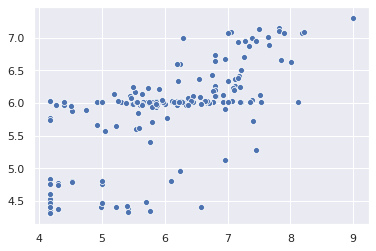

In [125]:
#Regresion model
random_state = 20
train_reg, test_reg = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train_reg, test_reg = train.copy(), test.copy()

data_new_reg = [i for i in data_new['bin']]

x_train_reg = [f for f in train_reg['bin']]
x_test_reg = [f for f in test_reg['bin']]
y_train_reg = [a for a in train_reg['pec50']]
y_test_reg = [a for a in test_reg['pec50']]

rfr = RandomForestRegressor(n_estimators=101,max_depth=4, random_state=random_state)
rfr.fit(x_train_reg, y_train_reg)

y_pred = rfr.predict(x_test_reg)
sns.scatterplot(x=y_test_reg, y=y_pred)


print("Regressor score:", rfr.score(x_test_reg, y_test_reg))

y_pred = rfr.predict(data_new_reg)
data_new['pec50_new'] = y_pred

df = pd.DataFrame({'pec50':[], 'pec50_new':[]})
df['pec50'] = data_new['pec50']
df['pec50_new'] = data_new['pec50_new']
print("Table wherre you see pec50 , and pec50_new after regression model")
display(df)

In [78]:
#create classification model after reggresion model
random_state = 20
thre = 7

#add new column
data_new['category_new_reg'] = np.where(data_new['pec50_new']>=thre, 1, 0)
 

#divided date for two sets: train and test
train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train, test = train.copy(), test.copy()
x_train = np.asarray([x for x in train['bin']])
x_test = np.asarray([x for x in test['bin']]) 
y_train = np.asarray([y for y in train['category_new_reg']])
y_test = np.asarray([y for y in test['category_new_reg']])

#RandomForesrClassifier
crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
crf.fit(x_train,y_train)

# prediction on test set
crf_predict = crf.predict(x_test)

#CLassification:
   #accuracy, spe, sen, MCC,
    #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
#confusion_matrix
print("Confusion_matrix for test set:")
conf_matrix = confusion_matrix(crf.predict(x_test), y_test)
print(conf_matrix)
TN, FP, FN, TP = conf_matrix.ravel()
d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
df = pd.DataFrame(data=d)
print("\n")
print(df)
print("\n")

#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
print("\n")
print("=== Classification Report ===")
print(classification_report(y_test, crf_predict))

# Performance metrics
errors = abs(crf_predict - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity:", round(TPR,3))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specifity:", round(TNR, 3))
#MCC
MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
print("MMC:", round(MCC, 3))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive predictive", round(PPV,3))
# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive", round(NPV,3))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive", round(FPR,3))
# False negative rate
FNR = FN/(TP+FN)
print("False negative", round(FNR,3))
# False discovery rate
FDR = FP/(TP+FP)
print("False discovery", round(FDR,3))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy", round(ACC,3))

#put data for pandas data_out
try:
    dda = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
      'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
    ddff = pd.DataFrame(data=dda)

    data_out_reg = data_out_reg.append(ddff, ignore_index = True)
    data_out_reg.drop_duplicates(keep='first', inplace=True)
except:
    ddaa = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
      'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
    data_out_reg = pd.DataFrame(data=ddaa)



y_score1 = crf.predict_proba(x_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))


Confusion_matrix for test set:
[[259   3]
 [  1   7]]


            predicted+  predicted-
0  actual+           7           3
1  actual-           1         259


Accuracy: 0.9851851851851852


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       260
           1       0.88      0.70      0.78        10

    accuracy                           0.99       270
   macro avg       0.93      0.85      0.89       270
weighted avg       0.98      0.99      0.98       270

Average absolute error: 0.01 degrees.
Sensitivity: 0.875
Specifity: 0.989
MMC: 0.775
Positive predictive 0.7
Negative predictive 0.996
False positive 0.011
False negative 0.125
False discovery 0.3
Overall accuracy 0.985
roc_auc_score for RandomForestClassification:  0.9985


In [76]:
data_out_reg.head()

threshold  Accuracy  Sensitiv.   Specif.       MCC  Positive pred  \
0        5.5  0.966667   0.992754  0.939394  0.934485       0.944828   
1        5.0  0.970370   0.986111  0.952381  0.940776       0.959459   
2        6.0  0.870370   0.939759  0.839572  0.734028       0.722222   
3        6.5  0.955556   1.000000  0.953125  0.716395       0.538462   
4        7.0  0.985185   0.875000  0.988550  0.775347       0.700000   

   Negative pred  False positive  False negative  
0       0.992000        0.060606        0.007246  
1       0.983607        0.047619        0.013889  
2       0.969136        0.160428        0.060241  
3       1.000000        0.046875        0.000000  
4       0.996154        0.011450        0.125000

In [100]:
data_out_reg.to_csv('data_out_reg_diferentthreshold_clasification_modelafter_reg.csv',  encoding='utf-8')

In [6]:
data_clas = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_diferent_threshold_clasification_model.csv')


In [7]:
print("Data for classifikation model(step 1)")
data_clas.head()


Data for classifikation model(step 1)


Unnamed: 0  threshold  Accuracy  Sensitiv.   Specif.       MCC  \
0           0        7.0  0.881481   1.000000  0.878327  0.397050   
1           1        5.0  0.918519   0.923611  0.912698  0.836310   
2           2        5.5  0.870370   0.852713  0.886525  0.740154   
3           3        6.0  0.800000   0.880000  0.781818  0.542414   
4           4        6.5  0.803704   0.923077  0.797665  0.362823   

   Positive pred  Negative pred  False positive  False negative  
0       0.179487       1.000000        0.121673        0.000000  
1       0.923611       0.912698        0.087302        0.076389  
2       0.873016       0.868056        0.113475        0.147287  
3       0.478261       0.966292        0.218182        0.120000  
4       0.187500       0.995146        0.202335        0.076923

In [110]:
data_clas_cros = pd.read_csv('/home/valeriia/bakalarka/bakalarka/vystup_Nsplits5,10_clasification_model.csv')
print("Data after croos validation for classification model (step1)")
data_clas_cros

Data after croos validation for classification model (step1)


Unnamed: 0  threshold  N_Split  Split  Accuracy           Sensitiv.  \
0            0        5.0      5.0    0.0  0.967593              0.8125   
1            1        5.0      5.0    1.0  0.921296  0.3333333333333333   
2            2        5.0      5.0    2.0  0.777778  0.8928571428571429   
3            3        5.0      5.0    3.0  0.861111  0.9807692307692307   
4            4        5.0      5.0    4.0  0.736111  0.8972602739726028   
..         ...        ...      ...    ...       ...                 ...   
70          70        7.0     10.0    5.0  0.944444                 NaN   
71          71        7.0     10.0    6.0  0.898148                 NaN   
72          72        7.0     10.0    7.0  0.787037                 0.9   
73          73        7.0     10.0    8.0  0.833333  0.7777777777777778   
74          74        7.0     10.0    9.0  0.805556                 NaN   

               Specif.                  MCC        Positive pred  \
0   0.9945652173913043   0.8669214468630108   0.9629629629629629   
1   0.9468599033816425  0.22741775761782826  0.21428571428571427   
2   0.6538461538461539   0.5656697125166719   0.7352941176470589   
3                 0.55   0.6379052256590134                 0.85   
4                  0.4   0.3484215771445816   0.7572254335260116   
..                 ...                  ...                  ...   
70  0.9444444444444444                  NaN                  0.0   
71  0.8981481481481481                  NaN                  0.0   
72  0.7755102040816326   0.4328313827668359   0.2903225806451613   
73  0.8383838383838383   0.4159681814955806  0.30434782608695654   
74  0.8055555555555556                  NaN                  0.0   

         Negative pred        False positive        False negative  
0   0.9682539682539683  0.005434782608695652                0.1875  
1   0.9702970297029703   0.05314009661835749    0.6666666666666666  
2                 0.85   0.34615384615384615   0.10714285714285714  
3   0.9166666666666666                  0.45  0.019230769230769232  
4   0.6511627906976745                   0.6   0.10273972602739725  
..                 ...                   ...                   ...  
70                 1.0   0.05555555555555555                   NaN  
71                 1.0   0.10185185185185185                   NaN  
72   0.987012987012987   0.22448979591836735                   0.1  
73  0.9764705882352941   0.16161616161616163    0.2222222222222222  
74                 1.0   0.19444444444444445                   NaN  

[75 rows x 12 columns]

In [4]:
data_clas_reg = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_reg_diferentthreshold_clasification_modelafter_reg.csv')
print("Data classifikation(which i built after regresion model)(step 2)")
data_clas_reg

Data classifikation(which i built after regresion model)(step 2)


Unnamed: 0  threshold  Accuracy  Sensitiv.   Specif.       MCC  \
0           0        5.5  0.966667   0.992754  0.939394  0.934485   
1           1        5.0  0.970370   0.986111  0.952381  0.940776   
2           2        6.0  0.870370   0.939759  0.839572  0.734028   
3           3        6.5  0.955556   1.000000  0.953125  0.716395   
4           4        7.0  0.985185   0.875000  0.988550  0.775347   

   Positive pred  Negative pred  False positive  False negative  
0       0.944828       0.992000        0.060606        0.007246  
1       0.959459       0.983607        0.047619        0.013889  
2       0.722222       0.969136        0.160428        0.060241  
3       0.538462       1.000000        0.046875        0.000000  
4       0.700000       0.996154        0.011450        0.125000